# TabTransformers
In this notebook I will be deploying the TabTransformers model on the IBLI dataset

https://huggingface.co/keras-io/tab_transformer

In [100]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns

from scipy.stats import f_oneway
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow import metrics
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, LayerNormalization, MultiHeadAttention, Add, Lambda, Dropout
from tensorflow.keras.models import Model
import keras_tuner as kt
from keras.metrics import MeanSquaredError, MeanAbsoluteError

In [62]:
keras.metrics.R2Score(
    class_aggregation="uniform_average", num_regressors=0, name="r2_score", dtype=None
)

<R2Score name=r2_score>

# Load and preprocess the data

In [63]:
#Load in the dataset
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/cattle_df.xlsx")
df = df.drop(['Unnamed: 0','advise_vip','purchase_bin','cs_cs_ratio_post_cattle','buy_nr_cattle','buy_cattle', 'ratio_insured_cattle', 'n_previd_cattle', 'wave', 'id'], axis=1)
df.head()

,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_cattle,number_minors,...,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip
0,No,25,Yes,No,Never attended,No,0,1,-188.170624,2,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes
1,Yes,27,Yes,No,Adult Education,No,0,0,-850.367249,2,...,Not working,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
2,Yes,29,No,No,Elementary,No,1,0,-5219.686523,2,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Professional and Organizational Sources,Christian,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
3,No,35,Yes,No,Never attended,No,0,0,-157.544266,3,...,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
4,No,60,Yes,No,Never attended,No,0,0,-158.881271,1,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes


In [64]:
columns_list = df.columns.tolist()
print(columns_list)


['afm_language', 'age_constant', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'expend', 'irrigated_land_bin', 'cs_cs_diff_post_cattle', 'number_minors', 'educ_child_recoded', 'activity_child_recoded', 'household_description', 'number_adults', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip']


In [1]:
#Log+1 transforming the dataset to improve the distribution

df['cs_diff_log'] = np.log(np.abs(df['cs_cs_diff_post_cattle']) + 1)
df[['cs_cs_diff_post_cattle', 'cs_diff_log']].head()

NameError: name 'np' is not defined

In [66]:
y = df['cs_diff_log']
X = df.drop(columns=['cs_diff_log', 'cs_cs_diff_post_cattle'])

In [67]:
categorical = X.select_dtypes(include=['object','category']).columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Deploy the TabTransformers model
The following website has been used as a guide for this implementation:

https://keras.io/examples/structured_data/tabtransformer/

In [68]:
#Encode and scale the data

label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
X[numerical] = scaler.fit_transform(X[numerical])

In [69]:
# Inputs
inputs = []
embeddings = []

# Embedding categorical features
for col in categorical:
    input_cat = Input(shape=(1,), name=col)
    vocab_size = X[col].nunique()
    embed_dim = min(50, (vocab_size + 1) // 2)
    
    embedding = layers.Embedding(input_dim=vocab_size + 1, output_dim=embed_dim)(input_cat)
    embedding = layers.Reshape((embed_dim,))(embedding)
    
    inputs.append(input_cat)
    embeddings.append(embedding)

# Numerical input
input_num = Input(shape=(len(numerical),), name="numerical")
inputs.append(input_num)
embeddings.append(input_num)

# Concatenate all embeddings + numerical
x = layers.Concatenate()(embeddings)

# Project everything to a fixed dimension for transformer block
hidden_dim = 64
x = layers.Dense(hidden_dim)(x)

#Adding a feed forward network to improve the model

def feed_forward_network(hidden_dim, ff_dim, dropout_rate=0.01):
    return tf.keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),   
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_dim)                    
    ])

# Transformer blocks
for _ in range(2):
    x1 = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x1[:, None, :], x1[:, None, :])
    attn_output = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(attn_output)
    attn_output = layers.Dropout(0.1)(attn_output)

    x2 = layers.Add()([x, attn_output])
    
    x3 = layers.LayerNormalization()(x2)
    ffn = feed_forward_network(hidden_dim=hidden_dim, ff_dim=hidden_dim*4)
    ffn_output = ffn(x3)
    x = layers.Add()([x2, ffn_output])

# Output for regression
output = layers.Dense(1)(x)

# Model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.R2Score()])


In [70]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construct TabTransformer input format
def make_tab_input(df, categorical, numerical):
    inputs = {col: df[col].values for col in categorical}
    inputs['numerical'] = df[numerical].values
    return inputs

X_train = make_tab_input(X_train_raw, categorical, numerical)
X_test = make_tab_input(X_test_raw, categorical, numerical)

In [71]:
X_train = {
    col: X_train_raw[col].values for col in categorical
}
X_train["numerical"] = X_train_raw[numerical].values

# Same for X_test
X_test = {
    col: X_test_raw[col].values for col in categorical
}
X_test["numerical"] = X_train_raw[numerical].values

In [72]:
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.9218 - mean_absolute_error: 1.7655 - r2_score: -1.3490 - val_loss: 3.4402 - val_mean_absolute_error: 1.3653 - val_r2_score: -0.0690
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0482 - mean_absolute_error: 1.2952 - r2_score: -0.0983 - val_loss: 3.6108 - val_mean_absolute_error: 1.3717 - val_r2_score: -0.1220
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1206 - mean_absolute_error: 1.2906 - r2_score: -0.0751 - val_loss: 3.7552 - val_mean_absolute_error: 1.3196 - val_r2_score: -0.1669
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9452 - mean_absolute_error: 1.2436 - r2_score: -0.0430 - val_loss: 3.4325 - val_mean_absolute_error: 1.3289 - val_r2_score: -0.0666
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0041 - mean_absolute_error: 1.2818 - r2_score: -0.0680 - val_loss: 3.7045 - val_mean_absolute_error: 1.4685 - val_r2_score: -0.1512
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1

# Hyperparameter tuning
using https://keras.io/keras_tuner/

In [137]:
def build_model(hp):
    # Hyperparameters
    hidden_dim = hp.Int('hidden_dim', min_value=32, max_value=128, step=32)
    ff_dim = hp.Int('ff_dim', min_value=128, max_value=512, step=32)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    num_heads = hp.Choice('num_heads', [2, 4, 8])
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    # Inputs
    inputs = []
    embeddings = []

    for col in categorical:
        input_cat = Input(shape=(1,), name=col)
        vocab_size = X[col].nunique()
        embed_dim = min(50, (vocab_size + 1) // 2)
        embedding = layers.Embedding(input_dim=vocab_size + 1, output_dim=embed_dim)(input_cat)
        embedding = layers.Reshape((embed_dim,))(embedding)
        inputs.append(input_cat)
        embeddings.append(embedding)

    input_num = Input(shape=(len(numerical),), name="numerical")
    inputs.append(input_num)
    embeddings.append(input_num)

    x = layers.Concatenate()(embeddings)
    x = layers.Dense(hidden_dim)(x)

    for _ in range(2):
        x1 = layers.LayerNormalization()(x)
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim // num_heads, dropout=dropout_rate)(
            x1[:, None, :], x1[:, None, :]
        )
        attn_output = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(attn_output)
        x2 = layers.Add()([x, attn_output])

        x3 = layers.LayerNormalization()(x2)
        ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(hidden_dim),
        ])
        ffn_output = ffn(x3)
        x = layers.Add()([x2, ffn_output])

    output = layers.Dense(1)(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse', metrics=[
            keras.metrics.R2Score(name='r2_score'), keras.metrics.MeanSquaredError(name='mse'), keras.metrics.MeanAbsoluteError(name='mae')
        ])
    return model

## RandomSearch

Random search selects combinations of hyperparameters at random from a defined search space. Instead of trying every single possibility, it samples a fixed number of random combinations. This is a faster method and often just as effective as grid search.

In [74]:
tuner = kt.RandomSearch(
    build_model,
    objective= kt.Objective('val_r2_score', direction='max') ,
    max_trials=15,
    executions_per_trial=2,
    directory='tuner_dir_v7',
    project_name='tabtransformer_tuning_v20'
)

tuner.search(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Reloading Tuner from tuner_dir_v7\tabtransformer_tuning_v20\tuner0.json


In [75]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"Best hidden_dim: {best_hps.get('hidden_dim')}")
print(f"Best ff_dim: {best_hps.get('ff_dim')}")

Best hidden_dim: 64
Best ff_dim: 320


C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Random search results

In [76]:
results = []

for i, trial in enumerate(tuner.oracle.trials.values()):
    hp = trial.hyperparameters.values
    val_r2 = trial.metrics.get_best_value('val_r2_score')
    val_mse = trial.metrics.get_best_value('val_mse')
    val_mae = trial.metrics.get_best_value('val_mae')
    res = {
        'trial_id': trial.trial_id,
        **hp,
        'val_r2_score': val_r2,
        'val_mse': val_mse,
        'val_mae': val_mae
    }
    results.append(res)

results_df = pd.DataFrame(results)

In [77]:
display_cols_r2 = ['trial_id', 'hidden_dim', 'ff_dim', 'dropout_rate', 'num_heads', 'learning_rate', 'val_r2_score','val_mse','val_mae']

#Create a table sorting on the R2 score
results_table_r2 = results_df[display_cols_r2].sort_values(by='val_r2_score', ascending=False)
results_table_r2.style.background_gradient(subset=['val_r2_score'], cmap='viridis_r').background_gradient(subset=['val_r2_score'], cmap='plasma_r')

,trial_id,hidden_dim,ff_dim,dropout_rate,num_heads,learning_rate,val_r2_score,val_mse,val_mae
4,03,64,320,0.300000,4,0.001000,-0.011568,3.196381,1.275739
7,01,96,128,0.100000,2,0.000100,-0.015040,3.207354,1.298901
8,14,32,416,0.300000,4,0.001000,-0.016885,3.213184,1.281611
9,11,32,480,0.100000,2,0.000100,-0.016992,3.213521,1.269831
3,00,32,128,0.300000,8,0.001000,-0.017297,3.214485,1.290067
10,13,64,320,0.100000,2,0.000100,-0.017728,3.215847,1.277973
11,06,32,384,0.400000,8,0.000100,-0.023182,3.233081,1.296092
6,02,128,384,0.200000,8,0.000100,-0.023727,3.234802,1.295047
5,12,96,256,0.100000,2,0.000100,-0.025135,3.239251,1.278966
2,09,64,448,0.200000,2,0.000100,-0.025157,3.239322,1.298430


## Hyperband

Hyperband is a so-called bandit-based optimisation algorithm that speeds up hyperparameter search. It tries many configurations quickly using fewer epochs and allocating more resources to the promising candidates.

In [135]:
tuner_v2 = kt.Hyperband(
    build_model,                
    objective= kt.Objective('val_r2_score', direction='max'),   
    max_epochs=50,              
    factor=3,                   
    directory='tuner_dir',      
    project_name='tabtransformer_tuning_v10',
    overwrite=True,             
    seed=42                
)

tuner_v2.search(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Trial 2 Complete [00h 00m 02s]

Best val_r2_score So Far: None
Total elapsed time: 00h 00m 03s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |96                |hidden_dim
384               |128               |ff_dim
0.4               |0.2               |dropout_rate
2                 |2                 |num_heads
0.0001            |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras\src\layers\input_spec.py", line 149, in assert_input_compatibility
    raise ValueError(
ValueError: Missing data for input "age_constant". You passed a data dictionary with keys ['afm_language', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'educ_child_recoded', 'activity_child_recoded', 'household_description', 'main_info_source_recoded', 'religion_recoded', 'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip', 'numerical']. Expected the following keys: ['afm_language', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'educ_child_recoded', 'activity_child_recoded', 'household_description', 'main_info_source_recoded', 'religion_recoded', 'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip', 'age_constant', 'expend', 'irrigated_land_bin', 'number_minors', 'number_adults', 'owns_phone']


## Hyperband results

In [79]:
results_hyperband = []

for i, trial in enumerate(tuner_v2.oracle.trials.values()):
    hp = trial.hyperparameters.values
    val_r2 = trial.metrics.get_best_value('val_r2_score')
    val_mse = trial.metrics.get_best_value('val_mse')
    val_mae = trial.metrics.get_best_value('val_mae')
    res = {
        'trial_id': trial.trial_id,
        **hp,
        'val_r2_score': val_r2,
        'val_mse': val_mse,
        'val_mae': val_mae
    }
    results_hyperband.append(res)

results_df_hyperband = pd.DataFrame(results_hyperband)

In [80]:
display_cols_r2 = ['trial_id', 'hidden_dim', 'ff_dim', 'dropout_rate', 'num_heads', 'learning_rate', 'val_r2_score','val_mse','val_mae']

#Create a table sorting on the R2 score
results_table_r2_hyperband = results_df_hyperband[display_cols_r2].sort_values(by='val_r2_score', ascending=False)
results_table_r2_hyperband.style.background_gradient(subset=['val_r2_score'], cmap='viridis_r').background_gradient(subset=['val_r2_score'], cmap='plasma_r')

,trial_id,hidden_dim,ff_dim,dropout_rate,num_heads,learning_rate,val_r2_score,val_mse,val_mae
19,0019,32,192,0.000000,8,0.000100,-0.005923,3.178545,1.286335
78,0078,96,192,0.000000,4,0.000100,-0.006160,3.179295,1.264916
80,0080,64,416,0.000000,4,0.001000,-0.006323,3.179809,1.276592
67,0067,64,512,0.400000,2,0.000100,-0.007420,3.183274,1.266595
83,0083,64,416,0.000000,4,0.001000,-0.009303,3.189224,1.305320
88,0088,32,192,0.100000,8,0.000100,-0.009739,3.190603,1.284968
86,0086,32,352,0.400000,2,0.001000,-0.010569,3.193224,1.296009
84,0084,128,416,0.200000,4,0.001000,-0.010872,3.194183,1.268263
70,0070,64,160,0.200000,2,0.000100,-0.013177,3.201468,1.292818
72,0072,64,512,0.400000,2,0.000100,-0.013266,3.201747,1.302440


## Visualizations

In [113]:
from scikeras.wrappers import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


In [120]:
X_train_array = list(X_train.values())[0]

In [121]:
best_model = tuner_v2.get_best_models(1)[0]

In [125]:
from copy import deepcopy
#Extract the permutation importances

def permutation_importance_keras(model, X_dict, y_true, metric=mean_squared_error, n_repeats=5):
    base_score = metric(y_true, model.predict(X_dict))
    importances = {}

    for key in X_dict:
        scores = []

        for _ in range(n_repeats):
            X_permuted = deepcopy(X_dict)
            # Permute the feature
            X_permuted[key] = np.random.permutation(X_permuted[key])
            score = metric(y_true, model.predict(X_permuted))
            scores.append(score)

        # Importance = how much the score gets worse when permuted
        importances[key] = np.mean(scores) - base_score

    return importances

In [131]:
importances = permutation_importance_keras(best_model, X_train, y_train)

sorted_importance = sorted(importances.items(), key=lambda x: x[1], reverse=True)

for feature, score_diff in sorted_importance:
    print(f"{feature}: ΔMSE = {score_diff:.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

C:\Users\daanm\AppData\Local\Temp\ipykernel_28656\2879136049.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="mako")


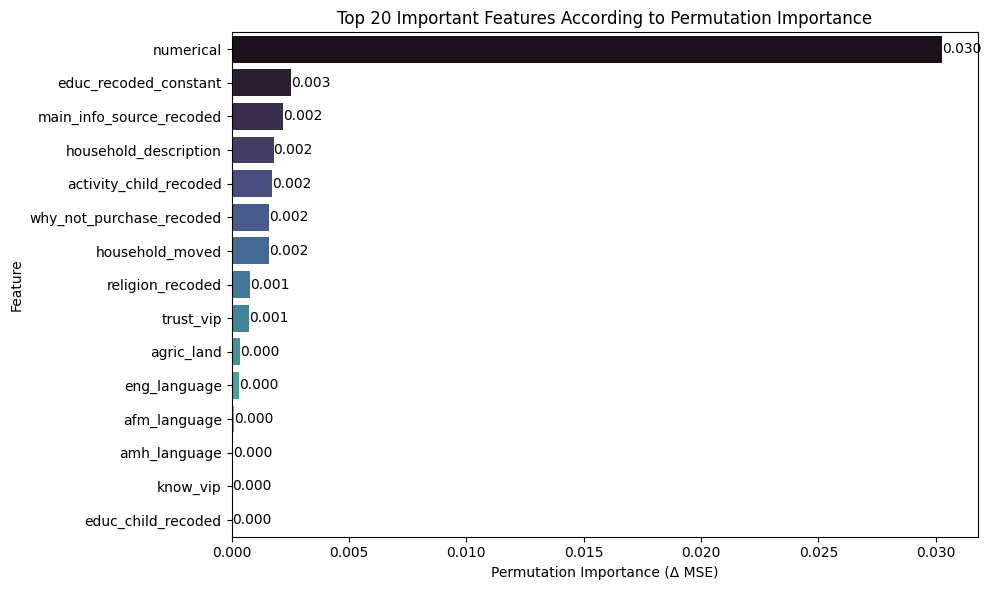

In [139]:
importance_df = pd.DataFrame(sorted_importance, columns=["Feature", "Importance"])
importance_df["Absolute Coefficient"] = importance_df["Importance"].abs()

# Top 20 features
top_features_df = importance_df.sort_values(by="Absolute Coefficient", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="mako")
plt.title("Top 20 Important Features According to Permutation Importance")
plt.xlabel("Permutation Importance (Δ MSE)")
plt.ylabel("Feature")

for i, value in enumerate(top_features_df["Absolute Coefficient"]):
    ax.text(value, i, f'{value:.3f}', color='black', va='center')

plt.tight_layout()
plt.savefig("top_features_permutation_importance_cattle.png", dpi=300)
plt.show()